# STEP 1: IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)

# STEP 2: LOAD DATASET

In [2]:
# Load Iris dataset
iris = load_iris()

df = pd.DataFrame(iris.data, columns=iris.feature_names)

df['species'] = iris.target
df['species_name'] = df['species'].map({0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'})

print(f"Dataset loaded: {df.shape}")
print(f"Samples: {len(df)}")
print(f"Features: {len(iris.feature_names)}")
print(f"Classes: {len(iris.target_names)}")

Dataset loaded: (150, 6)
Samples: 150
Features: 4
Classes: 3


# STEP 3: BASIC EDA

In [3]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species,species_name
0,5.1,3.5,1.4,0.2,0,Setosa
1,4.9,3.0,1.4,0.2,0,Setosa
2,4.7,3.2,1.3,0.2,0,Setosa
3,4.6,3.1,1.5,0.2,0,Setosa
4,5.0,3.6,1.4,0.2,0,Setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
 5   species_name       150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [5]:
df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [6]:
print(f"\nTarget Distribution (Balanced):")
print(df['species_name'].value_counts())
print(f"\nMissing Values: {df.isnull().sum().sum()} (None!)")


Target Distribution (Balanced):
species_name
Setosa        50
Versicolor    50
Virginica     50
Name: count, dtype: int64

Missing Values: 0 (None!)


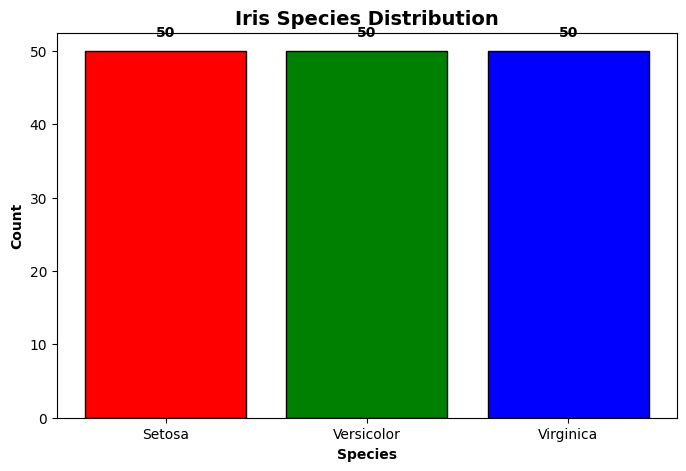

In [8]:
# Quick visualization
plt.figure(figsize=(8, 5))

species_counts = df['species_name'].value_counts()

plt.bar(species_counts.index, species_counts.values,
        color=['red', 'green', 'blue'], edgecolor='black')

plt.title('Iris Species Distribution', fontweight='bold', fontsize=14)
plt.ylabel('Count', fontweight='bold')
plt.xlabel('Species', fontweight='bold')

for i, v in enumerate(species_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.show()

# STEP 4: PREPARE DATA

In [9]:
X = df[iris.feature_names]
y = df['species']

print(f"Features: {list(X.columns)}")
print(f"Target: species (0=Setosa, 1=Versicolor, 2=Virginica)")
print(f"Shape: {X.shape}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target: species (0=Setosa, 1=Versicolor, 2=Virginica)
Shape: (150, 4)


# STEP 5: TRAIN-TEST SPLIT

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing samples: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"Features: {X_train.shape[1]}")


Training samples: 120 (80.0%)
Testing samples: 30 (20.0%)
Features: 4


# STEP 6: FEATURE SCALING (CRITICAL FOR SVM!)


⚠️ SVM is SENSITIVE to feature scales!"

    • Uses distance to hyperplane for classification"
    • Features with large ranges dominate the decision"
    • Scaling ensures all features contribute equally"

In [13]:
print("--- Before Scaling ---")
print(X_train.describe())

--- Before Scaling ---
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         120.000000        120.000000          120.00000   
mean            5.841667          3.048333            3.77000   
std             0.840926          0.448524            1.76852   
min             4.300000          2.000000            1.10000   
25%             5.100000          2.800000            1.60000   
50%             5.750000          3.000000            4.25000   
75%             6.400000          3.325000            5.10000   
max             7.900000          4.400000            6.90000   

       petal width (cm)  
count        120.000000  
mean           1.205000  
std            0.762663  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


In [12]:
# Apply StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for visualization
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [17]:
print("--- After Scaling (StandardScaler: mean=0, std=1) ---")
print(X_train_scaled.describe())

print("\n✅ Features scaled successfully!")
print("   All features now have mean ≈ 0 and std ≈ 1")

--- After Scaling (StandardScaler: mean=0, std=1) ---
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.200000e+02      1.200000e+02       1.200000e+02   
mean       -1.184238e-15     -1.998401e-15       4.958996e-16   
std         1.004193e+00      1.004193e+00       1.004193e+00   
min        -1.840983e+00     -2.347097e+00      -1.516067e+00   
25%        -8.856620e-01     -5.559895e-01      -1.232159e+00   
50%        -1.094638e-01     -1.082127e-01       2.725514e-01   
75%         6.667343e-01      6.194245e-01       7.551944e-01   
max         2.457961e+00      3.026225e+00       1.777262e+00   

       petal width (cm)  
count      1.200000e+02  
mean       1.669035e-15  
std        1.004193e+00  
min       -1.454945e+00  
25%       -1.191606e+00  
50%        1.250858e-01  
75%        7.834318e-01  
max        1.705116e+00  

✅ Features scaled successfully!
   All features now have mean ≈ 0 and std ≈ 1


# STEP 7: TRAIN DEFAULT MODEL (Linear Kernel)

Training SVM with Linear Kernel..."
- Linear Kernel: Finds a straight hyperplane to separate classes"
- Best for: Linearly separable data"


In [20]:
model_linear = SVC(kernel='linear', random_state=42)
model_linear.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=42)

In [21]:
# Predictions
y_pred_linear = model_linear.predict(X_test_scaled)

In [23]:
# Evaluation
acc_linear = accuracy_score(y_test, y_pred_linear)
f1_linear = f1_score(y_test, y_pred_linear, average='weighted')

print("--- Linear Kernel Performance ---")
print(f"Accuracy: {acc_linear:.4f} ({acc_linear*100:.1f}%)")
print(f"F1-Score: {f1_linear:.4f}")
print(f"Support Vectors: {model_linear.n_support_.sum()} out of {len(X_train_scaled)}")


--- Linear Kernel Performance ---
Accuracy: 1.0000 (100.0%)
F1-Score: 1.0000
Support Vectors: 23 out of 120


In [24]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_linear,
                            target_names=iris.target_names))

--- Classification Report ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



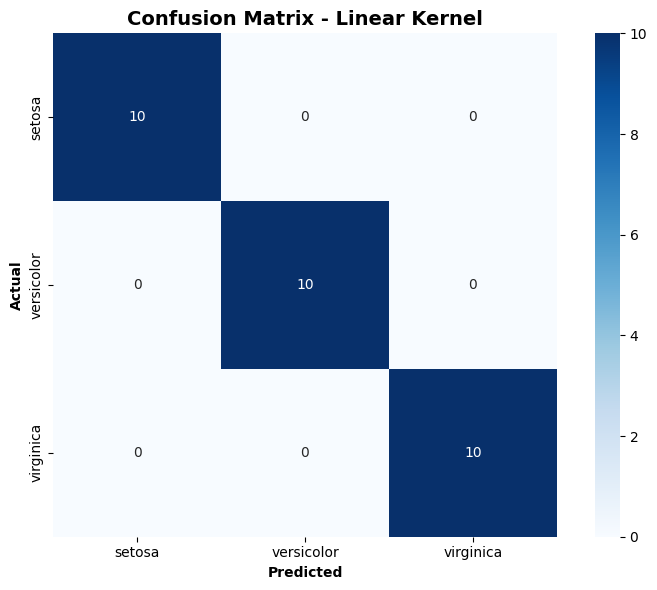

In [25]:
# Confusion Matrix
cm_linear = confusion_matrix(y_test, y_pred_linear)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues',
           xticklabels=iris.target_names,
           yticklabels=iris.target_names,
           cbar=True, square=True)
plt.title('Confusion Matrix - Linear Kernel', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# STEP 8: TRAIN RBF KERNEL MODEL


Training SVM with RBF (Radial Basis Function) Kernel..."
- RBF Kernel: Can find curved/complex decision boundaries"
- Best for: Non-linearly separable data"
- Most popular kernel in practice!

In [26]:
model_rbf = SVC(kernel='rbf', random_state=42)
model_rbf.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [27]:
# Predictions
y_pred_rbf = model_rbf.predict(X_test_scaled)

In [29]:
# Evaluation
acc_rbf = accuracy_score(y_test, y_pred_rbf)
f1_rbf = f1_score(y_test, y_pred_rbf, average='weighted')

print("--- RBF Kernel Performance ---")
print(f"Accuracy: {acc_rbf:.4f} ({acc_rbf*100:.1f}%)")
print(f"F1-Score: {f1_rbf:.4f}")
print(f"Support Vectors: {model_rbf.n_support_.sum()} out of {len(X_train_scaled)}")

--- RBF Kernel Performance ---
Accuracy: 0.9667 (96.7%)
F1-Score: 0.9666
Support Vectors: 47 out of 120


In [30]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_rbf,
                            target_names=iris.target_names))

--- Classification Report ---
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



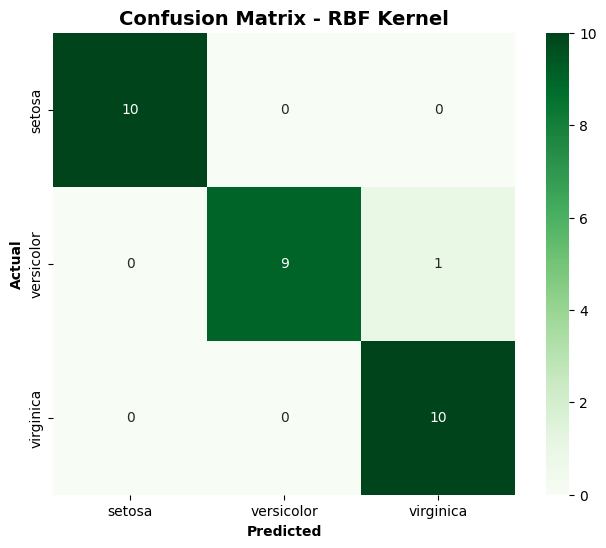

In [31]:
# Confusion Matrix
cm_rbf = confusion_matrix(y_test, y_pred_rbf)

plt.figure(figsize=(8, 6))

sns.heatmap(cm_rbf, annot=True, fmt='d', cmap='Greens',
           xticklabels=iris.target_names,
           yticklabels=iris.target_names,
           cbar=True, square=True)

plt.title('Confusion Matrix - RBF Kernel', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')

plt.show()

# STEP 9: COMPARE DIFFERENT KERNELS

In [33]:
kernels = ['linear', 'rbf', 'poly']
kernel_scores = []
kernel_models = []

for kernel in kernels:
    if kernel == 'poly':
        model = SVC(kernel=kernel, degree=3, random_state=42)
    else:
        model = SVC(kernel=kernel, random_state=42)

    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    kernel_scores.append(score)
    kernel_models.append(model)

    print(f"{kernel.upper():10s} kernel: {score:.4f} ({score*100:.1f}%)")


LINEAR     kernel: 1.0000 (100.0%)
RBF        kernel: 0.9667 (96.7%)
POLY       kernel: 0.9000 (90.0%)


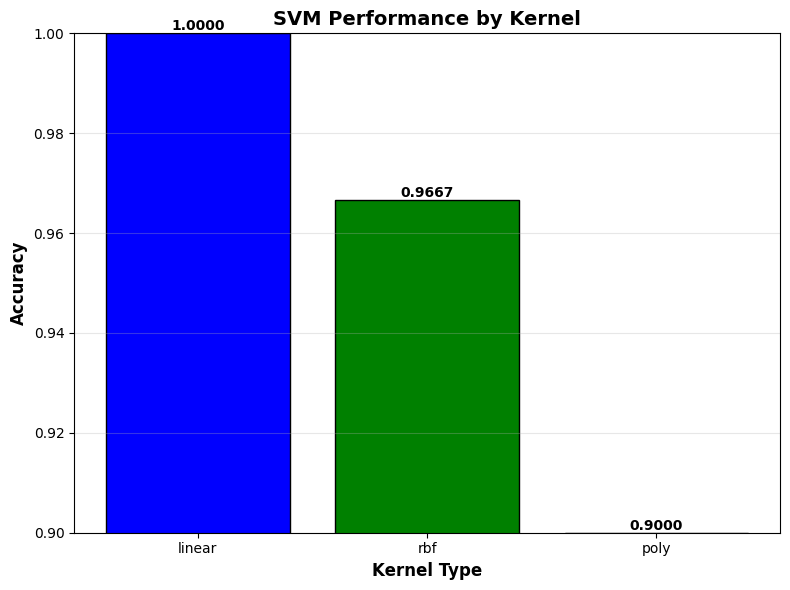


Best kernel: LINEAR (1.0000)


In [35]:
# Visualize
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'orange']
bars = plt.bar(kernels, kernel_scores, color=colors, edgecolor='black')

plt.ylabel('Accuracy', fontweight='bold', fontsize=12)
plt.xlabel('Kernel Type', fontweight='bold', fontsize=12)
plt.title('SVM Performance by Kernel', fontweight='bold', fontsize=14)
plt.ylim([0.90, 1.0])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

best_kernel = kernels[np.argmax(kernel_scores)]
print(f"\nBest kernel: {best_kernel.upper()} ({max(kernel_scores):.4f})")

# STEP 10: CROSS-VALIDATION


In [36]:
cv_scores = cross_val_score(model_rbf, X_train_scaled, y_train,
                             cv=5, scoring='accuracy', n_jobs=-1)

print(f"CV Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\n--- Comparison ---")
print(f"CV Accuracy (5-fold): {cv_scores.mean():.4f}")
print(f"Test Accuracy:        {acc_rbf:.4f}")
print(f"Difference:           {abs(cv_scores.mean() - acc_rbf):.4f}")

if abs(cv_scores.mean() - acc_rbf) < 0.05:
    print("\n✅ Model generalizes well!")
else:
    print("\n⚠️ Some gap - possible overfitting")

CV Accuracy Scores: [0.91666667 1.         0.95833333 0.95833333 1.        ]
Mean CV Accuracy: 0.9667 (+/- 0.0312)

--- Comparison ---
CV Accuracy (5-fold): 0.9667
Test Accuracy:        0.9667
Difference:           0.0000

✅ Model generalizes well!


# STEP 11: HYPERPARAMETER TUNING


In [37]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear']
}

print("\nRunning GridSearchCV...")
print("Expected time: 20-30 seconds...")

grid_search = GridSearchCV(
    SVC(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n--- Best Hyperparameters Found ---")
for param, value in grid_search.best_params_.items():
    print(f"✓ {param}: {value}")

print(f"Best CV Accuracy: {grid_search.best_score_:.4f}")


Running GridSearchCV...
Expected time: 20-30 seconds...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

--- Best Hyperparameters Found ---
✓ C: 1
✓ gamma: 0.1
✓ kernel: rbf
Best CV Accuracy: 0.9833


In [38]:
# Predict with tuned model
y_pred_tuned = grid_search.best_estimator_.predict(X_test_scaled)

In [40]:
acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

print("--- Tuned Model Performance ---")
print(f"Accuracy: {acc_tuned:.4f} ({acc_tuned*100:.1f}%)")
print(f"F1-Score: {f1_tuned:.4f}")
print(f"Support Vectors: {grid_search.best_estimator_.n_support_.sum()}")

print(f"\nImprovement over default: {(acc_tuned - acc_rbf)*100:+.2f}%")

--- Tuned Model Performance ---
Accuracy: 0.9667 (96.7%)
F1-Score: 0.9666
Support Vectors: 50

Improvement over default: +0.00%


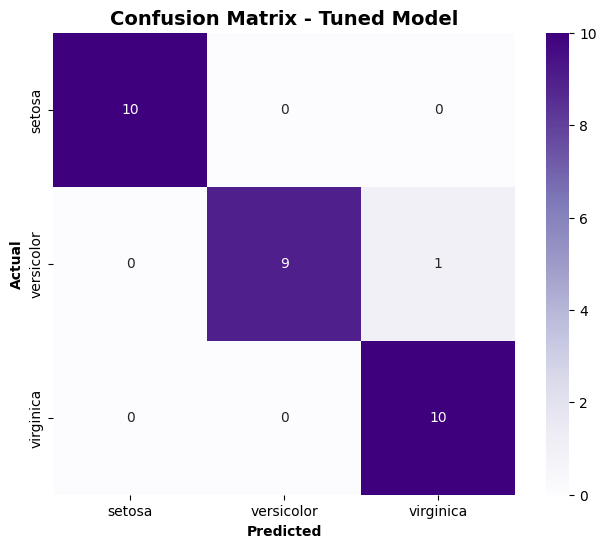

In [42]:
# Confusion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(8, 6))

sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Purples',
           xticklabels=iris.target_names,
           yticklabels=iris.target_names,
           cbar=True, square=True)

plt.title('Confusion Matrix - Tuned Model', fontweight='bold', fontsize=14)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')

plt.show()

# STEP 12: UNDERSTANDING C AND GAMMA

### Parameter Effects

* 💡 C (Regularization Parameter):"
    -  Small C (e.g., 0.1): Wider margin, more tolerance for errors"
    •                       Underfitting risk, better generalization"
    
    - Large C (e.g., 100): Narrow margin, less tolerance for errors"
    •                      Overfitting risk, fits training data closely"

* 💡 Gamma (Kernel Coefficient for RBF):"
    
   - Small gamma (e.g., 0.001): Smooth decision boundary"
   •                             Far points influence classification"
   -  Large gamma (e.g., 10): Complex decision boundary"
   •                          Only nearby points influence classification"

--- Testing C and Gamma Impact ---


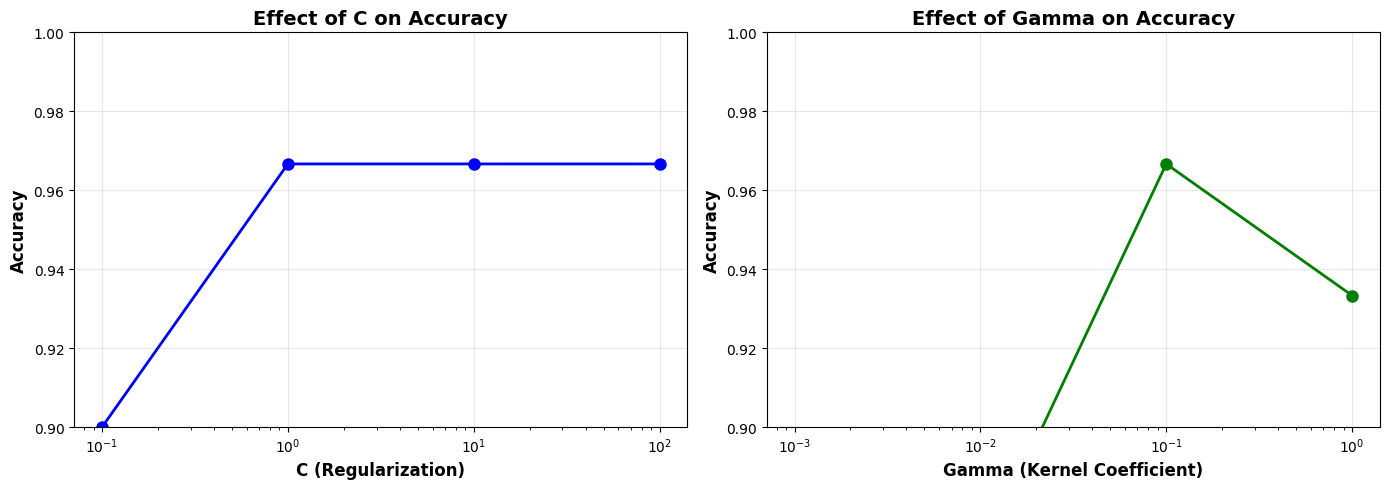


Optimal C: 1
Optimal Gamma: 0.1


In [44]:
# Visualize C and gamma effect on accuracy
print("--- Testing C and Gamma Impact ---")

C_values = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1, 1]

# Test C effect (fixed gamma)
c_scores = []
for c in C_values:
    model = SVC(C=c, gamma='scale', kernel='rbf', random_state=42)
    model.fit(X_train_scaled, y_train)
    c_scores.append(model.score(X_test_scaled, y_test))

# Test gamma effect (fixed C)
gamma_scores = []
for gamma in gamma_values:
    model = SVC(C=1, gamma=gamma, kernel='rbf', random_state=42)
    model.fit(X_train_scaled, y_train)
    gamma_scores.append(model.score(X_test_scaled, y_test))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# C effect
axes[0].plot(C_values, c_scores, 'o-', linewidth=2, markersize=8, color='blue')
axes[0].set_xscale('log')
axes[0].set_xlabel('C (Regularization)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
axes[0].set_title('Effect of C on Accuracy', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.90, 1.0])

# Gamma effect
axes[1].plot(gamma_values, gamma_scores, 'o-', linewidth=2, markersize=8, color='green')
axes[1].set_xscale('log')
axes[1].set_xlabel('Gamma (Kernel Coefficient)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
axes[1].set_title('Effect of Gamma on Accuracy', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.90, 1.0])

plt.tight_layout()
plt.show()

print(f"\nOptimal C: {grid_search.best_params_['C']}")
print(f"Optimal Gamma: {grid_search.best_params_['gamma']}")

# STEP 13: MODEL COMPARISON

In [46]:
comparison = pd.DataFrame({
    'Model': ['Linear Kernel', 'RBF Kernel', 'Tuned (GridSearch)'],
    'Accuracy': [acc_linear, acc_rbf, acc_tuned],
    'F1-Score': [f1_linear, f1_rbf, f1_tuned],
    'Kernel': ['linear', 'rbf', grid_search.best_params_['kernel']]
})

print(comparison.to_string(index=False))

best_idx = comparison['Accuracy'].idxmax()
print(f"\nBest Model: {comparison.loc[best_idx, 'Model']}")
print(f"Best Accuracy: {comparison.loc[best_idx, 'Accuracy']:.4f}")

             Model  Accuracy  F1-Score Kernel
     Linear Kernel  1.000000  1.000000 linear
        RBF Kernel  0.966667  0.966583    rbf
Tuned (GridSearch)  0.966667  0.966583    rbf

Best Model: Linear Kernel
Best Accuracy: 1.0000
